In [1]:
import os
import h5py
import numpy as np
import openslide

In [2]:
# ChatGPT generated 
# Create an HDF5 file
with h5py.File("Bag_ID.hdf5", "w") as hdf:

    # Add metadata
    metadata_group = hdf.create_group("Metadata")
    metadata_group.attrs["ID"] = "Sample_ID"
    metadata_group.attrs["Annotation"] = "Sample slide annotation"

    # Add Tiles group
    tiles_group = hdf.create_group("Tiles")
    tiles_group.attrs["Patch size"] = 256

    # Example tile
    tile_name = "Tile0001.png"
    tile_data = np.random.rand(256, 256)  # Simulated image data
    tile_dataset = tiles_group.create_dataset(tile_name, data=tile_data)

    # Metadata for the tile
    tile_metadata_group = tiles_group.create_group(f"{tile_name}_Metadata")
    tile_metadata_group.attrs["Coordinates"] = [100, 200]
    tile_metadata_group.attrs["Annotation"] = "Tile annotation"

    # Add Preprocessing group
    preprocessing_group = hdf.create_group("Preprocessing")

    # Metadata for preprocessing
    preprocessing_group.attrs["Parameter 1"] = "Value1"
    preprocessing_group.attrs["Parameter 2"] = "Value2"

    # Example mask
    mask_data = np.random.randint(0, 2, (256, 256))  # Simulated binary mask
    preprocessing_group.create_dataset("Mask.png", data=mask_data)

    # Example annotations
    annotations = "<annotations>...</annotations>"  # XML string
    preprocessing_group.create_dataset("Annotations.xml", data=np.bytes_(annotations))


In [3]:
# Taken from: 
# https://stackoverflow.com/questions/61133916/is-there-in-python-a-single-function-that-shows-the-full-structure-of-a-hdf5-fi
def h5_tree(val, pre=''):
    items = len(val)
    for key, val in val.items():
        items -= 1
        if items == 0:
            # the last item
            if type(val) == h5py._hl.group.Group:
                print(pre + '└── ' + key)
                h5_tree(val, pre+'    ')
            else:
                try:
                    print(pre + '└── ' + key + ' (%d)' % len(val))
                except TypeError:
                    print(pre + '└── ' + key + ' (scalar)')
        else:
            if type(val) == h5py._hl.group.Group:
                print(pre + '├── ' + key)
                h5_tree(val, pre+'│   ')
            else:
                try:
                    print(pre + '├── ' + key + ' (%d)' % len(val))
                except TypeError:
                    print(pre + '├── ' + key + ' (scalar)')


In [4]:
with h5py.File("Bag_ID.hdf5", "r") as hdf:
    h5_tree(hdf)


├── Metadata
├── Preprocessing
│   ├── Annotations.xml (scalar)
│   └── Mask.png (256)
└── Tiles
    ├── Tile0001.png (256)
    └── Tile0001.png_Metadata


In [11]:
# convert CLAM output to this more self-contained, organized format! 

clam_example = "/home/felipe/Projects/multiple-instance-learning/samples/PAIP/clam-pipeline-results/patches/001400-2019-05-00-01-01.h5"

with h5py.File(clam_example, "r") as hdf:
    h5_tree(hdf)


└── coords (24980)


In [12]:
with h5py.File(clam_example, "r") as hdf:
    hdf.visit(lambda x: print(x))
    print(hdf.get("coords"))
    coords = hdf["coords"][:]
    print(coords.shape)


coords
<HDF5 dataset "coords": shape (24980, 2), type "<i8">
(24980, 2)


In [13]:
patch_size = 512
print(15537 * (patch_size)**2 / 1e9, " GB")
# this is OK since hdf5 doesn't load everything in memery (data slicing)

4.072931328  GB


In [14]:
from openslide import open_slide

eg = open_slide("/home/felipe/Projects/multiple-instance-learning/samples/TCGA/raw/TCGA-QG-A5Z1-01Z-00-DX1.F3157C57-0F35-42D3-9CA5-C72D93F1BF89.svs")
for x, y in eg.properties.items():
    print(x, y)

aperio.AppMag 40
aperio.DSR ID resc3-dsr2
aperio.Date 11/12/13
aperio.DisplayColor 0
aperio.Exposure Scale 0.000001
aperio.Exposure Time 109
aperio.Filename TCGA-QG-A5Z1-01Z-00-DX1
aperio.Focus Offset 0.000000
aperio.ICC Profile ScanScope v1
aperio.ImageID 140722
aperio.Left 16.946754
aperio.LineAreaXOffset 0.011464
aperio.LineAreaYOffset -0.002805
aperio.LineCameraSkew -0.000153
aperio.MPP 0.2527
aperio.OriginalHeight 91350
aperio.OriginalWidth 113792
aperio.Parmset GOG136 on O: Drive
aperio.ScanScope ID SS1764CNTLR
aperio.StripeWidth 2032
aperio.Time 17:17:21
aperio.Time Zone GMT-05:00
aperio.Title TCGA-QG-A5Z1-01Z-00-DX1
aperio.Top 24.035141
aperio.User 2febe22f-3a9e-4b90-a075-1eaab6827626
openslide.associated.label.height 652
openslide.associated.label.width 663
openslide.associated.macro.height 631
openslide.associated.macro.width 1600
openslide.associated.thumbnail.height 768
openslide.associated.thumbnail.width 938
openslide.comment Aperio Image Library v12.0.11 
113792x91350 [0

In [15]:
from enum import Enum 
class FileExtension:
    JPG = "jpg"
    PNG = "png"
    SVS = "svs"
    XML = "xml"
    H5 = "h5"

In [16]:
from PIL import Image
def read_image(file_path):
    with Image.open(file_path) as img:
        img_array = np.array(img)  # Convert image to numpy array
    return img_array

In [27]:
def _fetch_clam_masks(fh, _dir):
    _id = fh["Slide"].attrs["ID"]
    path = os.path.join(_dir, f"{_id}.{FileExtension.JPG}")
    if os.path.exists(path):
        img = read_image(path)
        fh["Preprocessing"].create_dataset("Mask", data=img, compression="gzip")
        return fh 

In [28]:
def _fetch_clam_stitches(fh, _dir):
    _id = fh["Slide"].attrs["ID"]
    path = os.path.join(_dir, f"{_id}.{FileExtension.JPG}")
    if os.path.exists(path):
        img = read_image(path)
        fh["Preprocessing"].create_dataset("Stitch", data=img, compression="gzip")
        return fh 

In [39]:
from openslide import open_slide
from tqdm import tqdm

def _fetch_clam_patches(fh, _dir_patches):
    _id = fh["Slide"].attrs["ID"]
    path_patches = os.path.join(_dir_patches, f"{_id}.{FileExtension.H5}")
    # open h5 generated by clam, with (x,y) coordinates
    if os.path.exists(path_patches):
        with h5py.File(path_patches, "r") as hdf:
            coords = hdf["coords"][:]

    annots = None
    if fh["Slide"].attrs["Has_Tile_Annotations"]:
        annots = _read_tile_annotations()  # TODO: implement this thing
        
    # store all tile info
    tile_size = fh["Tiles"].attrs["Tile_Size"]
    
    fh["Tiles"].attrs["Total"] = coords.shape[0]
    
    fh["Tiles"].create_dataset("Coords", data=coords)
    if annots:
        fh["Tiles"].create_dataset("Annotations", data=annots)
    return fh 

In [40]:
import pandas as pd

def _read_slide_annotations_CRS1K(fh, csv_path):
    df = pd.read_csv(csv_path)
    ids, labels = df["slide_name"], df["slide_label"]
    match = labels[ids == fh["Slide"].attrs["ID"]]
    return match.values[0] if not match.empty else None

In [41]:
from openslide import open_slide
import json


In [42]:
def convert_clam_format(_id, 
                        slides_dir,
                        preprocessing_dir,
                        annotations_dir,
                        save_as,
                        annotations_description,
                        slide_annotations_handler,
                        has_tile_annotations=False,
                        tile_annotations_handler=None,
                        tile_size=256,
                        slide_extension=FileExtension.SVS,
                        dataset_alias=None
                        ):
    
    with h5py.File(save_as, "w") as hdf:
        hdf.attrs["Name"] = dataset_alias if dataset_alias else "unknown"
        
        # Add slide group
        slide_group = hdf.create_group("Slide")
        slide_group.attrs["ID"] = _id
        slide_group.attrs["Annotation_Description"] = json.dumps(annotations_description)
        slide_group.attrs["Has_Tile_Annotations"] = has_tile_annotations
        
        if has_tile_annotations:
            assert tile_annotations_handler is not None, "please supply a tile_annotations_handler"
            pass
        else:
            slide_annot = slide_annotations_handler(hdf, annotations_dir)
            slide_group.attrs["Annotation"] = slide_annot if slide_annot is not None else -1  # TODO: see how to handle this later
        
        
        slide_group.attrs["Extension"] = slide_extension
        slide_group.attrs["Path"] = os.path.join(slides_dir, f"{_id}.{slide_extension}") 
        
        # Add slide metadata
        wsi = open_slide(slide_group.attrs["Path"])
        slide_group.attrs["Dimensions"] = wsi.dimensions
        slide_group.attrs["Level_Dimensions"] = wsi.level_dimensions
        slide_group.attrs["Level_Downsamples"] = wsi.level_downsamples
        slide_group.attrs["Level_Count"] = wsi.level_count

        # Add Tiles group
        tiles_group = hdf.create_group("Tiles")
        tiles_group.attrs["Tile_Size"] = tile_size

        # Add Preprocessing group
        preprocessing_group = hdf.create_group("Preprocessing")

        # Metadata for preprocessing    # TODO: generate from .csv (clam output)
        preprocessing_group.attrs["Parameter_1"] = "Value_1"
        preprocessing_group.attrs["Parameter_2"] = "Value_2"
        
        # Fill with CLAM output data
        _fetch_clam_masks(hdf, os.path.join(preprocessing_dir, "masks"))
        _fetch_clam_stitches(hdf, os.path.join(preprocessing_dir, "stitches"))
        _fetch_clam_patches(hdf, os.path.join(preprocessing_dir, "patches"))
convert_clam_format("001400-2019-05-00-01-01",
                    slides_dir="samples/PAIP/raw",
                    preprocessing_dir="samples/PAIP/clam-pipeline-results",
                    save_as="Example.hdf5",
                    annotations_description={0: "My label"},
                    has_tile_annotations=False,
                    tile_size=256,
                    dataset_alias="PAIP"
                    )

In [43]:
def get_tile(fh, i):
    wsi = open_slide(fh["Slide"].attrs["Path"])
    assert 0 <= i < fh["Tiles"].attrs["Total"], f"Tile index should be less than {fh["Tiles"].attrs["Total"]}"
    print(fh["Tiles/Coords"])
    return wsi.read_region(
        fh["Tiles/Coords"][i], 0, (fh["Tiles"].attrs["Tile_Size"], fh["Tiles"].attrs["Tile_Size"])
    )

Preprocessing
Preprocessing/Mask
Preprocessing/Stitch
Slide
Tiles
Tiles/Coords
{"0": "My label"}
<HDF5 dataset "Coords": shape (24980, 2), type "<i8">


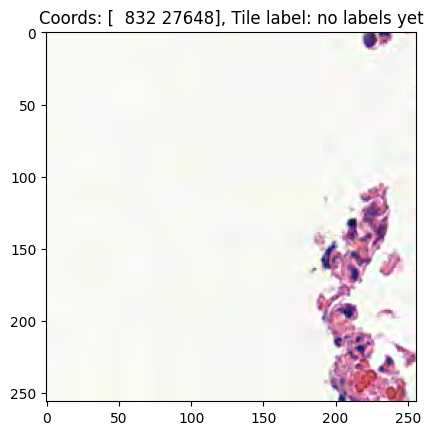

In [46]:
import matplotlib.pyplot as plt
with h5py.File("Example.hdf5", "r") as hdf:
    
    hdf.visit(lambda x: print(x))
    
    print(hdf["Slide"].attrs["Annotation_Description"])
    
    i = 10
    example = get_tile(hdf, i)

    plt.imshow(example)
    plt.title(f"Coords: {hdf["Tiles/Coords"][i]}, Tile label: no labels yet")
    plt.show()  